In [ ]:
!pip install torch

### RL Algo

State
deferable_demand * 3
flywheel_amt
1. demand(inst): float
2. sun: int (percentage)
2. buy_price: int (cents/joule)
3. sell_price: int (cents/joule)
5. stacked, use last X values

Action
1. import_export_amount (in joules): positive for import and negative for export
2. release_store_amount (in joules): positive for release and negative for store
3. for each deferrable demand: energy to allocate for that time tick as a float

In [1]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0, parent_directory)

import time

import numpy as np
from gen_data import getTicksForDay
from optimisation.utils.gen_utils import  get_ema


from policy import PolicyNetwork, ValueNetwork
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from naive import simulate_day_naive, trend_prediction
from algorithm import cur_tick_to_vect, future_ticks_to_vect, history_ticks_to_vect, compute_loss, compute_returns, environment_step, load_policy_network_checkpoint
from algorithm import ALLOCATION_MULTIPLIER, ALLOCATION_ABSOLUTE, STACKED_NUM, STATE_SIZE, ACTION_SIZE, TICK_LENGTH, RELEASE_STORE_MULTIPLIER, FUTURE_TICKS, IMPORT_EXPORT_MULTIPLIER, USE_TREND_FOR_ALLOCATION
from train_test_utils import plot_test_results

from copy import deepcopy

# Get number of files in checkpoints directory
def get_num_files():

    files = os.listdir("checkpoints")

    return str(len(files) + 1).zfill(2)
    # return len([name for name in os.listdir('checkpoints') if os.path.isfile(name)])

# REWARD_SCALING_FACTOR = 1
REWARD_SCALING_FACTOR = 1 / 100

def run_simulation(ticks, history_ticks, day, print_info=False):

    day_state = {
        "deferables": deepcopy(day.deferables),
        "flywheel_amt": 0
    }

    # print("Deferables: ", [[d.start, d.end] for d in day_state["deferables"]])

    log_probs = []
    rewards = []
    states = []
    costs = []
    penalties = []
    
    for i, tick in enumerate(ticks):
        state = []

        # Add deferable demand info
        deferables = day_state["deferables"]
        for j in range(len(deferables)):
            d = deferables[j]
            state.extend([d.energy, d.start, d.end])
        
        # Add store/release info
        state.append(day_state["flywheel_amt"])
        
        # Add tick info
        state.extend(cur_tick_to_vect(tick))
        state.extend(history_ticks_to_vect(history_ticks, STACKED_NUM))
        if FUTURE_TICKS > 0:
            state.extend(future_ticks_to_vect(history_ticks + [tick]))

        # Run policy network
        # TODO: Batch this?
        action, log_prob = policy_network.get_action(torch.tensor(state))
        log_probs.append(log_prob)

        # Environment step
        cost, penalty, _ = environment_step(action, tick, day_state, print_info=print_info)
        penalties.append(penalty)
        costs.append(cost)
        rewards.append(-(cost + penalty))
        states.append(state)

        history_ticks.append(tick)
        history_ticks.pop(0)


    return log_probs, rewards, costs, penalties, states

def simulate_day(day, ticks, history_ticks, runs_per_trajectory, print_info=False):
    global max_returns
    
    # Run simulation
    total_loss = 0
    trajectories = []

    # TODO: Batch this
    for i in range(runs_per_trajectory):
        log_probs, rewards, costs, penalties, states = run_simulation(ticks, history_ticks, day, print_info=print_info)
        trajectories.append((sum(rewards), sum(costs), sum(penalties)))
        # rewards = torch.tensor(rewards)
        baseline_costs = trend_prediction(day, ticks)

        rewards_scaled = [r * REWARD_SCALING_FACTOR for r in rewards]
        baseline_rewards_scaled = [-c * REWARD_SCALING_FACTOR for c in baseline_costs]

        # print(rewards_scaled)
        # print(baseline_rewards_scaled)

        returns = compute_returns(rewards_scaled, baseline_rewards_scaled)
        total_loss += compute_loss(log_probs, returns)


    average_loss = total_loss / RUNS_PER_TRAJECTORY
    policy_network.optimizer.zero_grad()
    average_loss.backward()
    policy_network.optimizer.step()

    return {
        "loss": average_loss.item(),
        "reward": sum([r[0] for r in trajectories]) / len(trajectories),
        "cost": sum([r[1] for r in trajectories]) / len(trajectories),
        "penalty": sum([r[2] for r in trajectories]) / len(trajectories)
    }

def train(naive_params, policy_network, num_epochs, runs_per_trajectory, filename):
    
    last_checkpoint = None
    history_ticks = [None] * STACKED_NUM
    min_cost = float('inf')
    
    results = []
    naive_costs = []
    trend_costs = []
    for i in range(num_epochs):
        day, ticks = getTicksForDay(i)

        last_checkpoint = {
            "mean_net": policy_network.mean_net.state_dict().copy(),
            "logstd": policy_network.logstd.clone(),
        }

        r = simulate_day(day, ticks, history_ticks, runs_per_trajectory, print_info=False)
        results.append(r)
        emas = get_ema([r["cost"] for r in results], 100)
        
        naive_costs.append(simulate_day_naive(day, ticks, satisfy_end=naive_params["satisfy_end"], use_flywheel=naive_params["use_flywheel"], export_extra=not naive_params["use_flywheel"]))
        trend_costs.append(trend_prediction(day, ticks))

        if last_checkpoint != None and emas[-1] < min_cost:
            min_cost = emas[-1]
            last_checkpoint["min"] = emas[-1]
            last_checkpoint["min_index"] = i
            torch.save(last_checkpoint, filename)
            

        if i % 100 == 0:
            print(f"Iteration {i}")
            print("Cost:", round(r["cost"], 3))
            print("Cost EMA (100): ", emas[-1])
            # cur_time = time.time()
            # print("Pen:", round(r["penalty"], 3))
            # print("Reward", round(r["reward"], 3))
            # print("Reward EMA (100): ", get_ema([r["reward"] for r in results], 100)[-1])
            # print(f"Time taken: {round(cur_time - start_time, 2)}s")
            print('-' * 20)
            print()

    return results, naive_costs, trend_costs
    

RUNS_PER_TRAJECTORY = 50
NUM_EPOCHS = 10000

num_files = get_num_files()
basename = f"{num_files}_e{NUM_EPOCHS}_r{RUNS_PER_TRAJECTORY}_am{ALLOCATION_MULTIPLIER}_rm{RELEASE_STORE_MULTIPLIER}_im{IMPORT_EXPORT_MULTIPLIER}_sta{STACKED_NUM}_abs{ALLOCATION_ABSOLUTE}_tre{USE_TREND_FOR_ALLOCATION}"

filename = f"checkpoints/{basename}.pth"
naive_params = {"use_flywheel": True, "satisfy_end": False}

policy_network = PolicyNetwork(state_size=STATE_SIZE, action_size=ACTION_SIZE, training=True)
results, naive_costs, trend_costs = train(naive_params, policy_network, NUM_EPOCHS, RUNS_PER_TRAJECTORY, filename)
# policy_network = load_policy_network_checkpoint(filename)

# Plotting
plot_test_results(results, naive_costs, trend_costs, naive_params, basename)

Iteration 0
Cost: 23611.215
Cost EMA (100):  23611.215202921434
--------------------

Iteration 100
Cost: 21342.746
Cost EMA (100):  22374.02719899489
--------------------

Iteration 200
Cost: 20955.555
Cost EMA (100):  21740.295877601482
--------------------

Iteration 300
Cost: 21760.103
Cost EMA (100):  22150.145382988925
--------------------

Iteration 400
Cost: 24415.313
Cost EMA (100):  21355.745515571492
--------------------

Iteration 500
Cost: 25579.961
Cost EMA (100):  21326.781115083206
--------------------

Iteration 600
Cost: 19277.908
Cost EMA (100):  19749.152340150475
--------------------

Iteration 700
Cost: 25090.964
Cost EMA (100):  20577.68138664404
--------------------

Iteration 800
Cost: 15109.884
Cost EMA (100):  20358.05322555252
--------------------

Iteration 900
Cost: 18715.111
Cost EMA (100):  20524.343457156792
--------------------

Iteration 1000
Cost: 16380.583
Cost EMA (100):  19759.337253699974
--------------------

Iteration 1100
Cost: 18326.891
Cost 

Exception: Exceeded max import/export amount

Training min:  17518.14
Min epoch:  7640
Start: 500050000

Day 500050000
EMA Cost: 17522.129
--------------------
Day 500050250
EMA Cost: 18438.347
--------------------
Day 500050500
EMA Cost: 17939.651
--------------------
Day 500050750
EMA Cost: 18227.0
--------------------


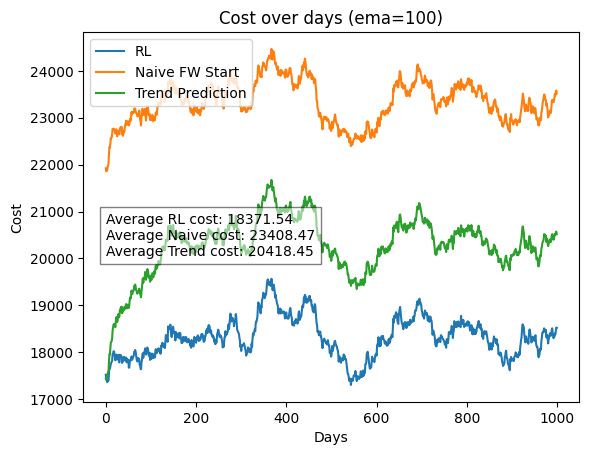

In [5]:
# table_md = costs_to_table_md([
#     ("RL", rl_costs),
#     ("Naive (EE) End", naive_ee_end),
# ])
# display(Markdown(table_md))

from random import randint
import sys
import os
import numpy as np


current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0, parent_directory)


from optimisation.utils.gen_utils import get_ema
from optimisation.train_test_utils import get_naive_label, run_validation
from optimisation.naive import simulate_day_naive, trend_prediction
from optimisation.gen_data import getDayData, getTickData, getTicksForDay
from algorithm import STATE_SIZE, ACTION_SIZE, load_policy_network_checkpoint
from algorithm import predict
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from random import randint

# basename = "07_e5000_r50_am2_rm8_im10_sta20_abs1_tre1"
basename = "08_e10000_r50_am2_rm0_im10_sta20_abs1_tre1"
# basename = "06_e5000_r50_am2_rm0_im10_sta20_abs1_tre1"

filename = f"checkpoints/{basename}.pth"
policy_network, min, min_epoch = load_policy_network_checkpoint(filename)

# start = randint(5000000, 6000000)
start = 500050000
print("Training min: ", round(min, 3))
print("Min epoch: ", min_epoch)
print("Start:", start)
print()

env = {
    "deferables": None,
    "flywheel_amt": 0
}

history_ticks = []


number_of_days = 1000

naive_params = {
    "satisfy_end": False,
    "use_flywheel": True
}

rl_costs, naive_costs, trend_costs = run_validation(start, number_of_days, policy_network, naive_params)

ema_amount = 100
plt.plot(get_ema(rl_costs, ema_amount), label="RL")
plt.plot(get_ema(naive_costs, ema_amount), label=get_naive_label(naive_params))
plt.plot(get_ema(trend_costs, ema_amount), label="Trend Prediction")

mid_y = (max(get_ema(naive_costs, ema_amount)) - max(get_ema(rl_costs, ema_amount)))//2 + max(get_ema(rl_costs, ema_amount)) * 0.9
plt.text(0, mid_y, 
f'''Average RL cost: {round(np.mean(rl_costs), 2)}
Average Naive cost: {round(np.mean(naive_costs), 2)}
Average Trend cost: {round(np.mean(trend_costs), 2)}''', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel("Days")
plt.ylabel("Cost")
plt.title("Cost over days (ema=100)")
plt.legend()
plt.savefig(f"plots/{basename}_val.png", dpi=500)
plt.show()

## Naive comparison

In [ ]:
import sys
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0, parent_directory)

from utils.gen_utils import costs_to_table_md, get_ema
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from naive import simulate_day_naive
from gen_data import getTicksForDay
from random import randint

import random

start = randint(5000000, 6000000)
print("Start day: ", start)
size = 1000

naive_fw_start = []
naive_ee_start = []
naive_fw_end = []
naive_ee_end = []

for day_id in range(start, start + size):
    day, ticks = getTicksForDay(day_id)
    naive_fw_start.append(simulate_day_naive(day, ticks, use_flywheel=True, satisfy_end=False))
    naive_ee_start.append(simulate_day_naive(day, ticks, export_extra=True, satisfy_end=False))
    naive_fw_end.append(simulate_day_naive(day, ticks, use_flywheel=True, satisfy_end=True))
    naive_ee_end.append(simulate_day_naive(day, ticks, export_extra=True, satisfy_end=True))

table_md = costs_to_table_md(
    [
        ("Naive (FW) Start", naive_fw_start),
        ("Naive (EE) Start", naive_ee_start),
        ("Naive (FW) End", naive_fw_end),
        ("Naive (EE) End", naive_ee_end),
    ]
)

display(Markdown(table_md))
plt.plot(get_ema(naive_fw_start, 100), label="Naive (FW) Start")
plt.plot(get_ema(naive_ee_start, 100), label="Naive (EE) Start")
plt.plot(get_ema(naive_fw_end, 100), label="Naive (FW) End")
plt.plot(get_ema(naive_ee_end, 100), label="Naive (EE) End")
plt.xlabel("Days")
plt.ylabel("Cost")
plt.title("Costs over days (ema=100)")
plt.legend()
plt.show()


In [ ]:
import sys
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0, parent_directory)
import matplotlib.pyplot as plt
import random
from gen_data import getTicksForDay
import numpy as np

rand_day = random.randint(0, 1000)
day, ticks = getTicksForDay(rand_day)

prices = np.array([t.sell_price for t in ticks])

print(prices.mean())
print(prices)
plt.plot(prices)